In [1]:
import os
import sys
main_path = os.path.abspath(os.path.join(os.path.dirname("pipeline_evaluation.ipynb"), ".."))
sys.path.insert(0, main_path)
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import matplotlib.pyplot as plt
import itertools
from scipy import sparse

In [2]:
from src.preprocesing import gen_dataset, gen_dataset_from_h5
from src.feature_extraction.text import ParameterSelector, MPTextGenerator, TextGeneration, CountVectorizer
from src.feature_extraction.vector_space_model import VSM
from src.feature_extraction.centroid import CentroidClass
from src.feature_selection.select_k_best import SelectKTop
from src.decomposition import LSA, PCA
from src.neighbors import KNeighborsClassifier
from src.feature_extraction.window_slider import TwoWaysSlider

In [3]:
d_train, l_train, meta_train = gen_dataset_from_h5("plasticc_augment_ddf_50")
classes = np.unique(l_train)
bands = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]

Object: 100%|████████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<?, ?it/s]


In [4]:
d_test, l_test, meta_test = gen_dataset_from_h5("plasticc_test_ddf_50")

Object: 100%|████████████████████████████████████████████████████████████████████████████████| 517/517 [00:00<?, ?it/s]


In [5]:
def first_iter_pipeline(win, wl, doc_kwargs, class_based=False, classes=None, normalize='l2',
                        use_idf=True, sublinear_tf=True):

    pipe = []

    # extract the word features from dataset as a bag-of-word
    text_gen = TextGeneration(win=win, wl=wl, direct_bow=True, **doc_kwargs)
    pipe.append(("textgen", text_gen))

    # transform the words to a basic VSM called bag-of-word
    # count_vec = CountVectorizer(alph_size=text_gen.alph_size,
    #                             irr_handler=text_gen.irr_handler,
    #                             word_length=text_gen.wl)
    # pipe.append(("count_vec", count_vec))

    # generate VSM following a fixed scheme
    vsm = VSM(class_based=False, classes=classes, norm=normalize, use_idf=use_idf,
              smooth_idf=True, sublinear_tf=sublinear_tf)
    pipe.append(("vsm", vsm))

    # we will do it without LSA

    # if class based, set centroid
    if class_based:
        centroid = CentroidClass(classes=classes)
        pipe.append(("prototype", centroid))

    # set classifier as 1-NN
    knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=class_based)
    pipe.append(("knn", knn))

    pipeline = Pipeline(pipe)
    return pipeline

def second_iter_pipeline(win, wl, doc_kwargs, class_based=False, classes=None, normalize='l2',
                        use_idf=True, sublinear_tf=True):

    pipe = []

    # extract the word features from dataset as a bag-of-word
    text_gen = TextGeneration(win=win, wl=wl, direct_bow=True, **doc_kwargs)
    pipe.append(("textgen", text_gen))

    # transform the words to a basic VSM called bag-of-word
    # count_vec = CountVectorizer(alph_size=text_gen.alph_size,
    #                             irr_handler=text_gen.irr_handler,
    #                             word_length=text_gen.wl)
    # pipe.append(("count_vec", count_vec))

    # generate VSM following a fixed scheme
    vsm = VSM(class_based=False, classes=classes, norm=normalize, use_idf=use_idf,
              smooth_idf=True, sublinear_tf=sublinear_tf)
    pipe.append(("vsm", vsm))

    # use LSA with fixed number of components
    lsa = LSA(sc=6 * (5 ** wl), algorithm="randomized", n_iter=5, random_state=None, tol=0.)
    pipe.append(("red", lsa))

    # if class based, set centroid
    if class_based:
        centroid = CentroidClass(classes=classes)
        pipe.append(("prototype", centroid))

    # set classifier as 1-NN
    knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=class_based)
    pipe.append(("knn", knn))

    pipeline = Pipeline(pipe)
    return pipeline

In [6]:
doc_kwargs = {
        "alphabet_size": np.array([4]),
        "quantity": np.array(["mean"]),
        "irr_handler": "#",
        "mean_bp_dist": "normal",
        "verbose": True
    }
class_based = True  # options: True, False
normalize = 'l2'  # options: None, l2
use_idf = True  # options: True, False
sublinear_tf = True  # options: True, False

pipeline = second_iter_pipeline(80, 5, doc_kwargs, class_based=class_based, classes=classes, normalize=normalize,
                                   use_idf=use_idf, sublinear_tf=sublinear_tf)

In [20]:
text_gen = TextGeneration(win=80, wl=5, direct_bow=True, **doc_kwargs)
x = text_gen.transform(d_train)

[win: 80.000000.3, wl: 5]: 100%|█████████████████████████████████████████████████████| 675/675 [00:16<00:00, 40.85it/s]


In [21]:
%time
vsm = VSM(class_based=False, classes=classes, norm=normalize, use_idf=use_idf,
              smooth_idf=True, sublinear_tf=sublinear_tf)
x2 = vsm.fit_transform(x, y=l_train)

Wall time: 0 ns


In [22]:
%time
lsa = LSA(sc=401, algorithm="randomized", n_iter=5, random_state=None, tol=0.)
print(x2.shape)
x3 = lsa.fit_transform(x2, y=l_train)
print(x3.shape)

Wall time: 0 ns
(675, 18750)
(675, 400)


In [23]:
%%time
centroid = CentroidClass(classes=classes)
x4 = centroid.fit_transform(x3, y=l_train)
print(x4.shape)

(14, 400)
Wall time: 430 ms


In [24]:
%time
knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=class_based)
knn.fit(x4, classes)

Wall time: 0 ns


KNeighborsClassifier(classes=array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]),
                     useClasses=True)

In [25]:
%time
x_ = text_gen.transform(d_test)
x2_ = vsm.transform(x_)
x3_ = lsa.transform(x2_)
pred = knn.predict(x3_)
print(balanced_accuracy_score(l_test, pred))

[win: 80.000000.3, wl: 5]:   0%|▏                                                      | 2/517 [00:00<00:25, 19.83it/s]

Wall time: 0 ns


[win: 80.000000.3, wl: 5]: 100%|█████████████████████████████████████████████████████| 517/517 [00:19<00:00, 26.77it/s]


0.3238095238095239


In [69]:
%%time
pipeline.fit(d_train, l_train)

Wall time: 52.1 s


Pipeline(steps=[('textgen', TextGeneration(verbose=False, win=80, wl=5)),
                ('vsm',
                 VSM(classes=array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]),
                     sublinear_tf=True)),
                ('red', LSA(sc=18750)),
                ('prototype',
                 CentroidClass(classes=array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]))),
                ('knn',
                 KNeighborsClassifier(classes=array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]),
                                      useClasses=True))])

In [45]:
%%time
pipeline.score(d_test, l_test)

Wall time: 19.6 s


0.2978723404255319

In [70]:
%%time
l_pred = pipeline.predict(d_test)

Wall time: 19.1 s


In [7]:
text_gen = MPTextGenerator(bands=bands, n_jobs=6, direct_bow=True, win=80, wl=5, **doc_kwargs)
x = text_gen.fit_transform(d_train)

In [8]:
x

<675x18750 sparse matrix of type '<class 'numpy.int32'>'
	with 26139 stored elements in Compressed Sparse Row format>

In [12]:
def cv_score(d_train, l_train, win, wl, doc_kwargs,
             class_based=False, classes=None, normalize='l2',
             use_idf=True, sublinear_tf=True):
    text_gen = MPTextGenerator(bands=bands, n_jobs=6, win=win, wl=wl, direct_bow=True, **doc_kwargs)
    x = text_gen.fit_transform(d_train)
    
    vsm = VSM(class_based=False, classes=classes, norm=normalize, use_idf=use_idf,
              smooth_idf=True, sublinear_tf=sublinear_tf)
    lsa = LSA(sc=401, algorithm="randomized", n_iter=5, random_state=None, tol=0.)
    centroid = CentroidClass(classes=classes)
    knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=class_based)
    pipeline = Pipeline([("vsm", vsm), ("lsa", lsa), ("centroid", centroid), ("knn", knn)])

    scores = cross_val_score(pipeline, x, y=l_train, cv=10, n_jobs=6, verbose=2)
    print("===> MEAN score [win={}, wl={}]:".format(win, wl), np.mean(scores), "+-", np.std(scores))
    return scores, pipeline, text_gen

In [13]:
scores, pipeline, text_gen = cv_score(d_train, l_train, 80, 5, doc_kwargs, 
                                      class_based=class_based, classes=classes, 
                                      normalize=normalize, use_idf=use_idf, 
                                      sublinear_tf=sublinear_tf)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    7.2s remaining:    7.2s


===> MEAN score [win=80, wl=5]: 0.3807945566286216 +- 0.024634738302733307


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   11.6s finished


In [17]:
x = text_gen.fit_transform(d_train)

In [22]:
len(np.where(np.sum(x, axis=1) == 0)[0])

0

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="YlGnBu"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

Confusion matrix, without normalization


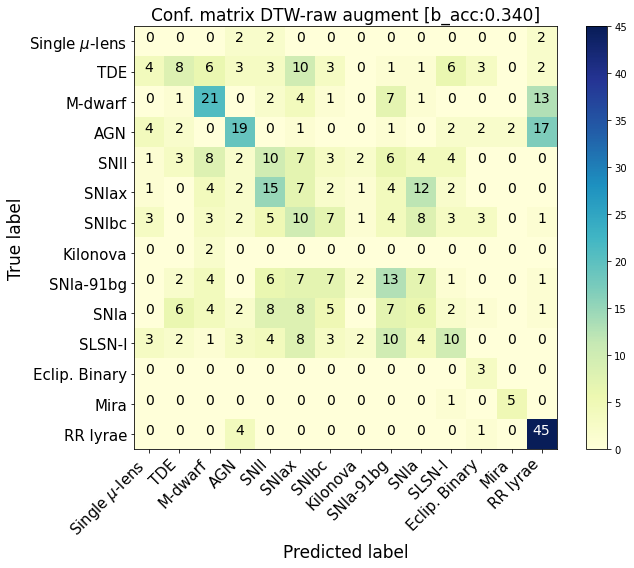

In [56]:
plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
}

reorder = [6, 15, 65, 88, 42, 52, 62, 64, 67, 90, 95, 16, 53, 92]
classes_names = [plot_labels_extra_short[x] for x in reorder]
cnf_matrix2 = confusion_matrix(l_test, l_pred, labels=reorder)
fig = plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix2, classes=classes_names, normalize=False,
                          title='Conf. matrix DTW-raw augment [b_acc:%.3f]' % balanced_accuracy_score(l_test, l_pred))

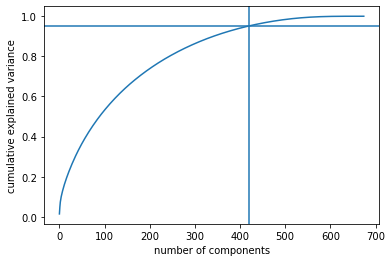

In [75]:
plt.plot(np.cumsum(pipeline['red'].explained_variance_ratio_))
plt.axhline(0.95)
plt.axvline(420)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');